In [29]:
!cd ../src/ && python3 setup.py install

running install
running bdist_egg
running egg_info
writing torchSODE.egg-info/PKG-INFO
writing dependency_links to torchSODE.egg-info/dependency_links.txt
writing top-level names to torchSODE.egg-info/top_level.txt
reading manifest file 'torchSODE.egg-info/SOURCES.txt'
writing manifest file 'torchSODE.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_ext
building 'torchSODE' extension
gcc -pthread -B /opt/conda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/opt/conda/lib/python3.6/site-packages/torch/include -I/opt/conda/lib/python3.6/site-packages/torch/include/torch/csrc/api/include -I/opt/conda/lib/python3.6/site-packages/torch/include/TH -I/opt/conda/lib/python3.6/site-packages/torch/include/THC -I/usr/local/cuda/include -I/opt/conda/include/python3.6m -c solver_interface.cpp -o build/temp.linux-x86_64-3.6/solver_interface.o -DTORCH_API_INCLUDE_EXTENSION_H -DTORC

In [1]:
import torchdiffeq
import torchSODE
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import statistics

# Van der Pol testing

## Torchdiffeq

In [2]:
class LSys(nn.Module):
    def __init__(self, F, func, mu):
        super().__init__()
        self.F = F
        self.func = func
        self.mu = mu
        
    def forward(self, t, x):
        return self.F@(self.func(x, mu))

In [3]:
def van_der_pol(x, mu):
    n = x.size(0)//2
    return torch.cat([x[n:], mu*(1-x[:n]**2)*x[n:]-x[:n]])

## torchSODE

In [4]:
def test(l1, l2, l3, l4, method, steps, new_dt, end, tol=1e-9, debug=True):
    tlist = l1
    tlist2 = l2
    tlist3 = l3
    tlist4 = l4
    
    F = torch.Tensor([[1]]).cuda()
    y0_orig = torch.Tensor([2.0, 0.5]).cuda()
    fy_orig = torch.Tensor([2.0, 0.5]).cuda()
    y = y0_orig
    x = 0

    s = time.time()
    if(debug): print(F, "\n\n", y, x)

    result = torch.Tensor(1).cuda()
    
    new_p_dt = new_dt

    while x < end:
        fy = y
        if(debug): print(F, x, y, fy)
        new_dt = torchSODE.solve(F, y, fy, new_p_dt, steps, method, tol, tol)
        x += (new_p_dt) * steps
        
        tlist4.append(new_p_dt)
        
        if(new_dt > 0): new_p_dt = new_dt
        if(debug): print(new_p_dt)
        if(debug): print(F, x, y, fy)

        tlist.append(y[0].cpu())
        tlist2.append(y[1].cpu())
        tlist3.append(x)
        result = torch.cat((result, y), 0)
    end = time.time() - s

In [5]:
def save_image(name, number, list_0, list_t=list()):
    if(len(list_t)):
        plt.plot(list_t, list_0)
    else:
        plt.plot(list_0)
    plt.savefig(name + number + '.png')
    plt.close()
        

In [6]:
def save_single_image(name, number, list_0, list_1, list_t=list()):
    if (len(list_t)):
        plt.plot(list_t, list_0)
        plt.plot(list_t, list_1)
    else:
        plt.plot(list_0)
        plt.plot(list_1)
    plt.savefig(name + number + '.png')
    plt.close()

In [7]:
def save_images(version, list_t, list_dt, list_1, list_2, mu, tol, method, dt):
    name = version + '-' + method + '-pol-' + str(mu) + '-' 
    if method == 'DOPRI5':
        name = name + str(tol) + '_'
        if(mu < 5):
            save_single_image(name, '0', list_1, list_2, list_t)
            save_image(name, '2', list_dt, list_t)
        else:
            save_image(name, '0', list_1, list_t)
            save_image(name, '1', list_2, list_t)
            save_image(name, '2', list_dt, list_t)
    elif method in ('Euler', 'RK4'):
        name = name + str(dt).replace('.', '-') + '_'
        if(mu < 5) :
            save_single_image(name, '0', list_1, list_2, list_t)
        else:
            save_image(name, '0', list_1)
            save_image(name, '1', list_2)
    else:
        print('Error')

In [8]:
def stats(dopri_list_dt):
    return min(dopri_list_dt), max(dopri_list_dt), statistics.mean(dopri_list_dt), statistics.median(dopri_list_dt), len(dopri_list_dt)

In [9]:
def run(mu, end, method, dt, tol=1e-9, steps=1, debug=False):
    list_1 = list()
    list_2 = list()
    list_t = list()
    list_dt = list()
    version = '3'
    test(list_1, list_2, list_t, list_dt, method, steps, dt, end, tol, debug)
    save_images(version, list_t, list_dt, list_1, list_2, mu, tol, method, dt)
    if(method == 'DOPRI5'):
        print("Min, Max, Mean, Median, Steps")
        print(stats(list_dt))
    return list_1, list_2, list_t, list_dt
    

# Mu = 2

In [15]:
mu = 2
end = 20

## torchdiffeq

In [11]:
F = torch.Tensor([[1, 0], [0, 1]])
sys = LSys(F, van_der_pol, mu)
x0 = torch.Tensor([2, 0.5])
t = torch.linspace(0,end,200)
s = time.time()
traj = torchdiffeq.odeint(sys, x0, t, method='dopri5')
end = time.time() - s

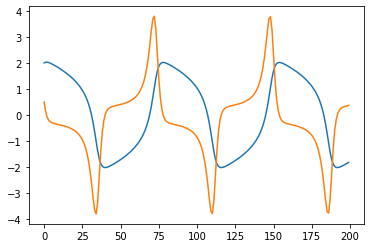

In [12]:
plt.plot(traj)
plt.show()

## torchSODE

## Euler

In [16]:
l1, l2, lt, ldt = run(mu, end, 'Euler', 0.01)

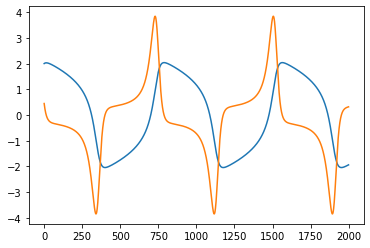

In [17]:
plt.plot(l1)
plt.plot(l2)
plt.show()

## Classical Runge-Kutta

In [18]:
l1, l2, lt, ldt = run(mu, end, 'RK4', 0.01)

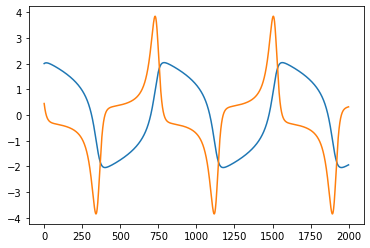

In [19]:
plt.plot(l1)
plt.plot(l2)
plt.show()

## Dormand Prince

In [20]:
l1, l2, lt, ldt = run(mu, end, 'DOPRI5', 0.01, 1e-10)

Min, Max, Mean, Median, Steps
(8.947159949457273e-05, 0.029850834980607033, 0.0008348737123002784, 0.00019962717487942427, 23959)


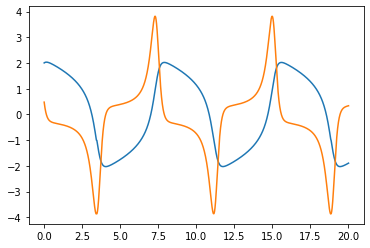

In [21]:
plt.plot(lt, l1) 
plt.plot(lt, l2)
plt.show()

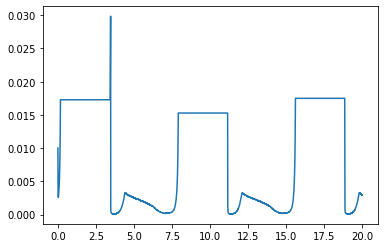

In [22]:
plt.plot(lt, ldt) 
plt.show()

In [23]:
l1, l2, lt, ldt = run(mu, end, 'DOPRI5', 0.01, 1e-9)

Min, Max, Mean, Median, Steps
(0.0007973039173521101, 0.07649611681699753, 0.008051547493354265, 0.0019658487290143967, 2484)


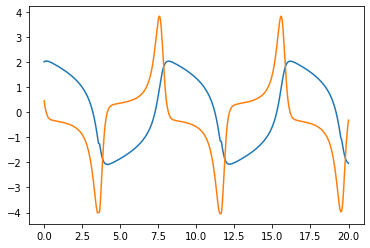

In [24]:
plt.plot(lt, l1)
plt.plot(lt, l2)
plt.show()

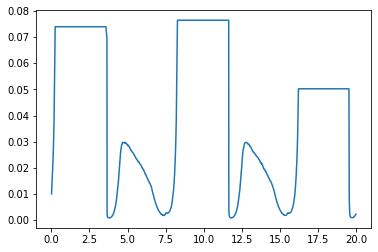

In [25]:
plt.plot(lt, ldt) 
plt.show()

In [26]:
l1, l2, lt, ldt = run(mu, end, 'DOPRI5', 0.01, 1e-8)

Min, Max, Mean, Median, Steps
(0.007053410168737173, 0.2363603711128235, 0.07869094342182507, 0.03174271248281002, 256)


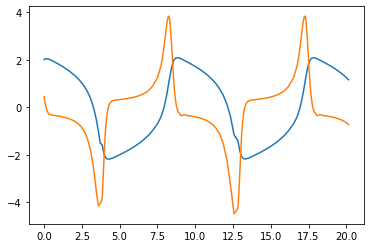

In [27]:
plt.plot(lt, l1)
plt.plot(lt, l2)
plt.show()

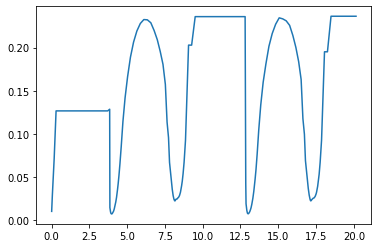

In [28]:
plt.plot(lt, ldt) 
plt.show()

# Mu = 100

In [37]:
mu = 100
end = 450

## torchdiffeq

In [11]:
F = torch.Tensor([[1, 0], [0, 1]])
sys = LSys(F, van_der_pol, mu)
x0 = torch.Tensor([2, 0.5])
t = torch.linspace(0,end,45000)
s = time.time()
traj = torchdiffeq.odeint(sys, x0, t, method='dopri5')
end = time.time() - s

In [12]:
traj1 = [x[0] for x in traj]
traj2 = [x[1] for x in traj]

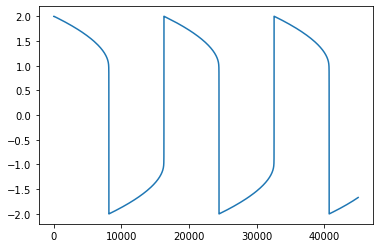

In [13]:
plt.plot(traj1)
plt.show()

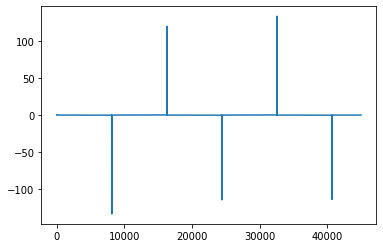

In [14]:
plt.plot(traj2)
plt.show()

## torchSODE

## Dormand Prince

#### 1e-11

In [ ]:
l1, l2, lt, ldt = run(mu, end, 'DOPRI5', 0.0001, 1e-11)

In [ ]:
plt.plot(lt, l1) 
plt.show()

In [ ]:
plt.plot(lt, l2) 
plt.show()

In [ ]:
plt.plot(lt, ldt) 
plt.show()

#### 1e-10

In [39]:
l1, l2, lt, ldt = run(mu, end, 'DOPRI5', 0.0001, 1e-10)

Min, Max, Mean, Median, Steps
(5.199932218147296e-08, 0.07382232695817947, 0.000671075959778727, 1.2792497017244386e-07, 670566)


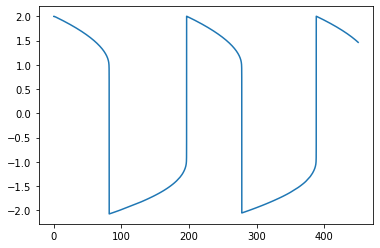

In [40]:
plt.plot(lt, l1) 
plt.show()

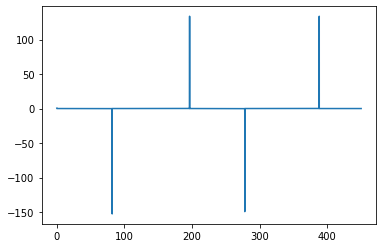

In [41]:
plt.plot(lt, l2)
plt.show()

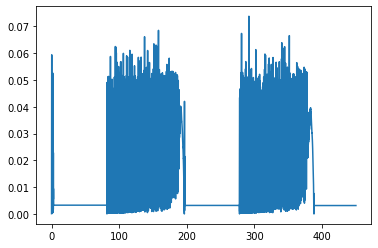

In [42]:
plt.plot(lt, ldt) 
plt.show()

#### 1e-9

In [43]:
l1, l2, lt, ldt = run(mu, end, 'DOPRI5', 0.001, 1e-9)

Min, Max, Mean, Median, Steps
(5.297692382555397e-07, 0.2682413160800934, 0.0036788715304061533, 0.0007111580343917012, 122323)


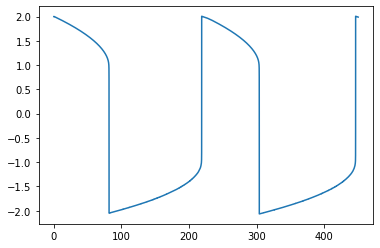

In [44]:
plt.plot(lt, l1) 
plt.show()

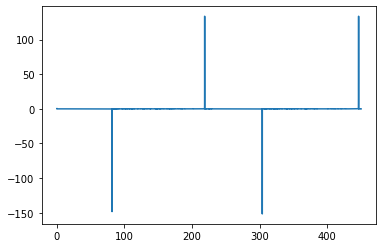

In [45]:
plt.plot(lt, l2) 
plt.show()

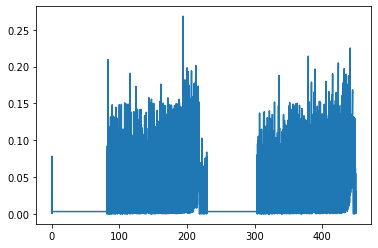

In [46]:
plt.plot(lt, ldt) 
plt.show()

#### 1e-8

In [47]:
l1, l2, lt, ldt = run(mu, end, 'DOPRI5', 0.01, 1e-8)
dopri_mean_dt = stats(ldt)[2]

Min, Max, Mean, Median, Steps
(4.678536242863629e-06, 0.7512994408607483, 0.0077986034429618255, 0.0029534490313380957, 57713)


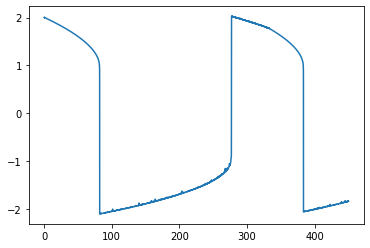

In [48]:
plt.plot(lt, l1) 
plt.show()

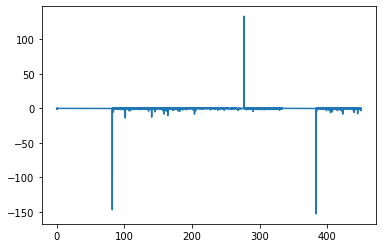

In [49]:
plt.plot(lt, l2) 
plt.show()

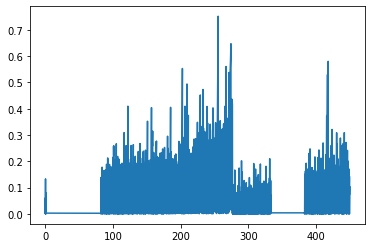

In [50]:
plt.plot(lt, ldt) 
plt.show()

#### 1e-7

In [51]:
l1, l2, lt, ldt = run(mu, end, 'DOPRI5', 0.01, 1e-7)

Min, Max, Mean, Median, Steps
(1.0857741472136695e-05, 0.524014949798584, 0.011427977275316364, 0.0005586283514276147, 39380)


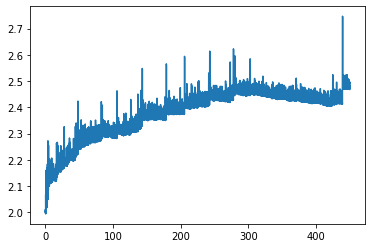

In [52]:
plt.plot(lt, l1) 
plt.show()

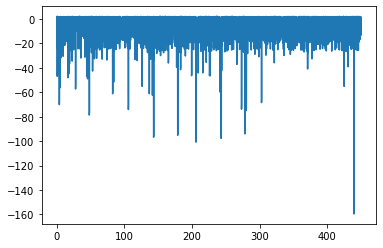

In [53]:
plt.plot(lt, l2) 
plt.show()

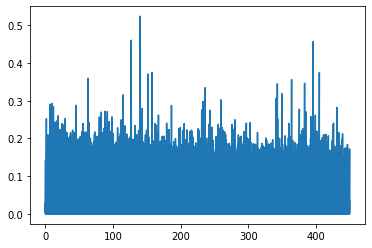

In [54]:
plt.plot(lt, ldt) 
plt.show()

## RK 4

In [21]:
l1, l2, _, _ = run(mu, end, 'RK4', 0.002)

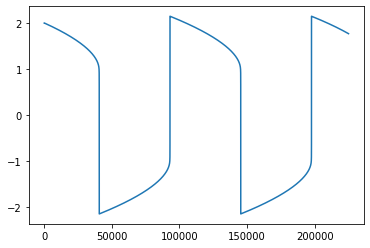

In [22]:
plt.plot(l1) 
plt.show()

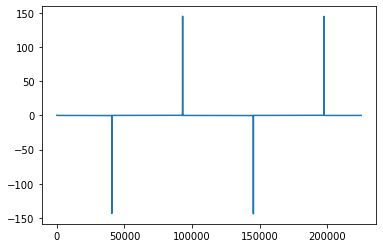

In [23]:
plt.plot(l2) 
plt.show()

In [24]:
l1, l2, _, _ = run(mu, end, 'RK4', 0.0077986034429618255)

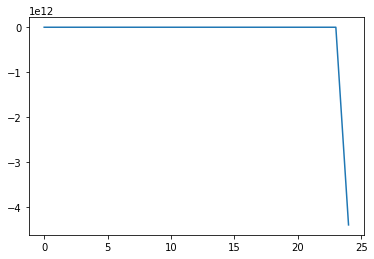

In [25]:
plt.plot(l1) 
plt.show()

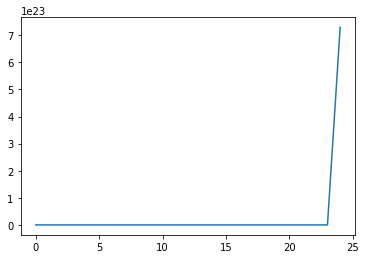

In [26]:
plt.plot(l2) 
plt.show()